Импорт модулей

In [153]:
import numpy as np
import os
import cv2
import keras
from matplotlib.pyplot import imshow
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet101
from keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Activation, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


Загрузка данных

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
train_horses_dir = os.path.join('/content/drive/MyDrive/data_analystic/lab2/horse-or-human/horses')  # директория с картинками котов для обучения
train_human_dir = os.path.join('/content/drive/MyDrive/data_analystic/lab2/horse-or-human/humans')
num_horses_tr = len(os.listdir(train_horses_dir))
num_human_tr = len(os.listdir(train_human_dir))
print('total train dataset size:', num_horses_tr + num_human_tr)

total train dataset size: 1027


Определение констант

In [156]:
train_path = "/content/drive/MyDrive/data_analystic/lab2/horse-or-human"
val_path = "/content/drive/MyDrive/data_analystic/lab2/validation-horse-or-human"
img_size = 300
batch_size = 80
epochs = 12
nb_classes = 2 
img_width, img_height = 150, 150 
input_shape = (img_width, img_height,3)
tr_ratio = .05


Вывод изображений из датасета

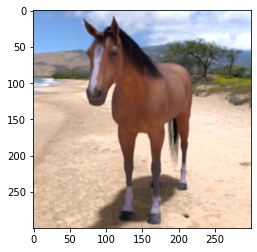

In [157]:
img_path = '/content/drive/MyDrive/data_analystic/lab2/horse-or-human/horses/horse02-0.png'
image = cv2.cvtColor(cv2.imread(cv2.os.path.join(img_path)), cv2.COLOR_BGR2RGB)
imshow(image)

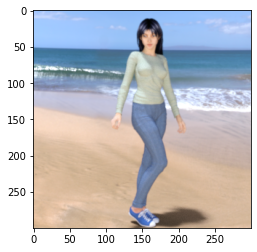

In [158]:
img_path = '/content/drive/MyDrive/data_analystic/lab2/horse-or-human/humans/human01-16.png'
image = cv2.cvtColor(cv2.imread(cv2.os.path.join(img_path)), cv2.COLOR_BGR2RGB)
imshow(image)

Ссоздание генераторов

In [159]:
train_gen_data = ImageDataGenerator(rescale=1. / 255)

val_data_gen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_gen_data.flow_from_directory(train_path,
                                                     target_size=(img_width, img_height),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

val_generator = val_data_gen.flow_from_directory(val_path,
                                                   target_size=(img_width, img_height),
                                                   batch_size=batch_size,
                                                   class_mode='categorical')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Создание и обучение сети Resnet50

In [160]:
RN50 = ResNet50(include_top=False, #Первый слой не полносвязный
                   weights='imagenet', #Использование весов, предобученных на Imagenet
                   input_shape=(img_size,img_size,3)) 

for layer in RN50.layers:
    layer.trainable = False

x = RN50.output
x = GlobalAveragePooling2D()(x) #Добавляем слой в модель

predictions = Dense(nb_classes, activation='relu')(x)
model = Model(RN50.input, predictions)
model.summary()
model.compile(optimizer='nadam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_25[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [161]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_generator.n // batch_size,
                    verbose=1)

Epoch 1/12
12/12 [==============================] - 11s 704ms/step - loss: 1.2793 - accuracy: 0.5507 - val_loss: 0.4929 - val_accuracy: 0.7750
Epoch 2/12
12/12 [==============================] - 7s 617ms/step - loss: 0.6805 - accuracy: 0.5570 - val_loss: 0.4888 - val_accuracy: 0.8292
Epoch 3/12
12/12 [==============================] - 7s 607ms/step - loss: 0.6575 - accuracy: 0.5784 - val_loss: 0.4504 - val_accuracy: 0.8833
Epoch 4/12
12/12 [==============================] - 7s 612ms/step - loss: 0.6388 - accuracy: 0.6118 - val_loss: 0.3931 - val_accuracy: 0.9333
Epoch 5/12
12/12 [==============================] - 7s 619ms/step - loss: 0.6160 - accuracy: 0.6691 - val_loss: 0.3618 - val_accuracy: 0.8958
Epoch 6/12
12/12 [==============================] - 7s 635ms/step - loss: 0.6628 - accuracy: 0.6580 - val_loss: 0.4015 - val_accuracy: 0.8917
Epoch 7/12
12/12 [==============================] - 7s 613ms/step - loss: 0.6536 - accuracy: 0.5960 - val_loss: 1.2895 - val_accuracy: 0.8042
Epoch

Построение графиков

In [162]:
class Graph:
  def __init__(self, epochs):
    self.epochs = epochs
  def draw(self, data, data2, data_label, data2_label):
    plt.figure(figsize=(20,5))
    plt.plot(history.history[data], color = 'b', label=data_label)
    plt.plot(history.history[data2], color= 'r', label=data2_label)
    plt.legend()
    plt.show()
    plt.clf()

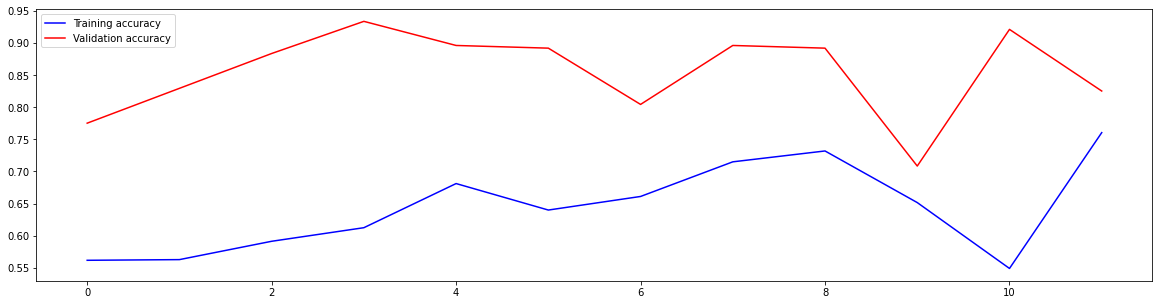

<Figure size 432x288 with 0 Axes>

In [163]:
curve = Graph(epochs)
curve.draw('accuracy','val_accuracy',"Training accuracy","Validation accuracy")

СОздание и обучение сети Resnet101

In [164]:
RN101 = ResNet101(input_shape=(img_size, img_size, 3),
                      weights='imagenet', 
                      include_top=False) 

for layer in RN101.layers:
    layer.trainable = False                      

x = RN101.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(nb_classes, activation='softmax')(x)
model = Model(RN101.input, predictions)
model.summary()
model.compile(optimizer='nadam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_26[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [165]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_generator.n // batch_size,
                    verbose=1)

Epoch 1/12
12/12 [==============================] - 14s 800ms/step - loss: 0.6935 - accuracy: 0.5079 - val_loss: 0.6616 - val_accuracy: 0.5500
Epoch 2/12
12/12 [==============================] - 8s 635ms/step - loss: 0.6846 - accuracy: 0.5430 - val_loss: 0.6231 - val_accuracy: 0.6625
Epoch 3/12
12/12 [==============================] - 8s 638ms/step - loss: 0.6748 - accuracy: 0.6223 - val_loss: 0.5815 - val_accuracy: 0.8625
Epoch 4/12
12/12 [==============================] - 8s 646ms/step - loss: 0.6640 - accuracy: 0.6740 - val_loss: 0.5528 - val_accuracy: 0.8250
Epoch 5/12
12/12 [==============================] - 8s 641ms/step - loss: 0.6555 - accuracy: 0.6810 - val_loss: 0.5177 - val_accuracy: 0.8750
Epoch 6/12
12/12 [==============================] - 8s 636ms/step - loss: 0.6449 - accuracy: 0.7115 - val_loss: 0.4960 - val_accuracy: 0.8708
Epoch 7/12
12/12 [==============================] - 8s 634ms/step - loss: 0.6357 - accuracy: 0.6907 - val_loss: 0.4785 - val_accuracy: 0.8542
Epoch

Построение графиков

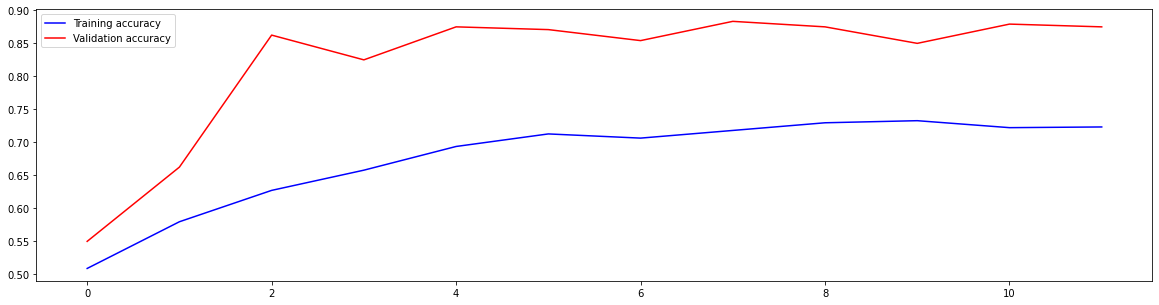

<Figure size 432x288 with 0 Axes>

In [166]:
curve = Graph(epochs)
curve.draw('accuracy','val_accuracy',"Training accuracy","Validation accuracy")

Создание и обучение сети Resnet152

In [167]:
RN152V2 = ResNet152V2(input_shape=(img_size,img_size,3),
                      weights='imagenet', 
                      include_top=False) 

for layer in RN152V2.layers:
    layer.trainable = False

x = RN152V2.output
x = GlobalAveragePooling2D()(x) # Добавляем слой в модель

predictions = Dense(nb_classes, activation='softmax')(x)
model = Model(RN152V2.input, predictions)
model.summary()
model.compile(optimizer='nadam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_27[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

Построение графиков

In [168]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n // batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    validation_steps=val_generator.n // batch_size,
                    verbose=1)

Epoch 1/12
12/12 [==============================] - 17s 892ms/step - loss: 0.9531 - accuracy: 0.6409 - val_loss: 0.2224 - val_accuracy: 0.8958
Epoch 2/12
12/12 [==============================] - 8s 656ms/step - loss: 0.0467 - accuracy: 0.9952 - val_loss: 0.1689 - val_accuracy: 0.9333
Epoch 3/12
12/12 [==============================] - 8s 656ms/step - loss: 0.0153 - accuracy: 0.9977 - val_loss: 0.1157 - val_accuracy: 0.9500
Epoch 4/12
12/12 [==============================] - 8s 657ms/step - loss: 0.0174 - accuracy: 0.9938 - val_loss: 0.1055 - val_accuracy: 0.9542
Epoch 5/12
12/12 [==============================] - 8s 661ms/step - loss: 0.0050 - accuracy: 0.9995 - val_loss: 0.0929 - val_accuracy: 0.9625
Epoch 6/12
12/12 [==============================] - 8s 666ms/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.0891 - val_accuracy: 0.9708
Epoch 7/12
12/12 [==============================] - 8s 659ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0776 - val_accuracy: 0.9708
Epoch

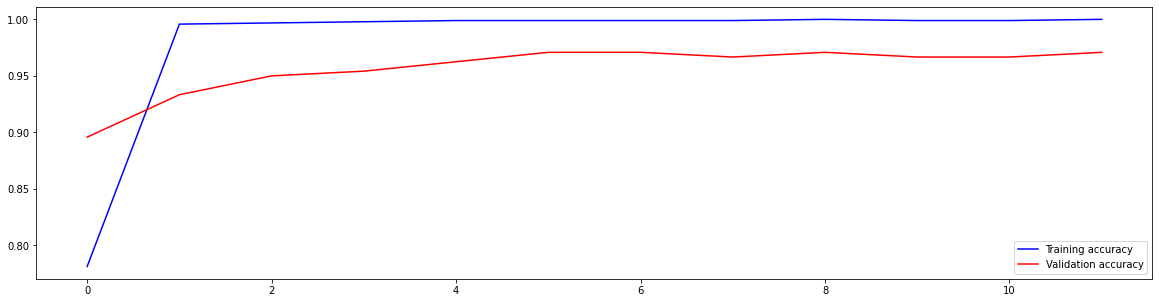

<Figure size 432x288 with 0 Axes>

In [169]:
curve = Graph(epochs)
curve.draw('accuracy','val_accuracy',"Training accuracy","Validation accuracy")